## Example code to reproduce the results of *Developing a Victorious Strategy to the Second Strong Gravitational lensing Data Challenge* by Bom et al.

This notebook is used with a subsample of the dataset that was used in the paper, using the HJY+VIS(repeated) configuration

In [ ]:
import tensorflow as tf
import os
from tensorflow import keras
import efficientnet as efn
import sklearn.metrics as sk_metrics
import numpy as np
from tensorflow_addons import optimizers
import matplotlib.pyplot as plt

In [ ]:
def get_fbeta(rec, prec, beta2):
    """Calculate the Fbeta score:
    Fbeta = (1+beta2) * (rec*prec) / ((beta2*prec) + rec)
    Arguments
        rec:float, recall value
        prec: float, precision value
        beta2: float, beta squared"""
    return (1+beta2) * (rec*prec) / ((beta2*prec) + rec)
    

def best_fbeta(rec, prec, beta2=0.001):
    """Get the best Fbeta score for several recall and precision values 
    Arguments
            rec: array, recall values for each threshold
            prec: array, precision values for each threshold
            beta2: float beta squared"""
    scores = [get_fbeta(rec[i], prec[i], beta2) for i in range(rec.shape[0])]
    return max(scores)

def plot_hjy(img, ax=None):
    h_norm = (img[:,:,:1] - img[:,:,:1].min()) / np.ptp(img[:,:,:1])
    j_norm = (img[:,:,1:2] - img[:,:,1:2].min()) / np.ptp(img[:,:,1:2])
    y_norm = (img[:,:,2:3] - img[:,:,2:3].min()) / np.ptp(img[:,:,2:3])
    hjy_norm = np.concatenate([h_norm, j_norm, y_norm], axis=-1)
    
    if ax is None:
        f, ax = plt.subplots()
    ax.imshow(hjy_norm, interpolation='nearest', cmap='gray')
    return None


In [ ]:
tf.keras.optimizers.RectifiedAdam = optimizers.RectifiedAdam

In [ ]:
%config Completer.use_jedi=False

Load images and labels, prepare VIS band for input to EfficientNet

In [ ]:
data_dir = '/tf/bernardo/Challenge2/data'
model_dir = '/tf/bernardo/Challenge2/data'

In [ ]:
images_vis0 = np.load(os.path.join(data_dir, 'images_vis_newpre_git.npy'))
images_hjy = np.load(os.path.join(data_dir, 'images_hjy_newpre_git.npy'))
is_lens = np.load(os.path.join(data_dir, 'is_lens_git.npy'))
images_vis = np.concatenate([images_vis0, images_vis0, images_vis0], axis=-1)

Plot some example images, lenses and non-lenses

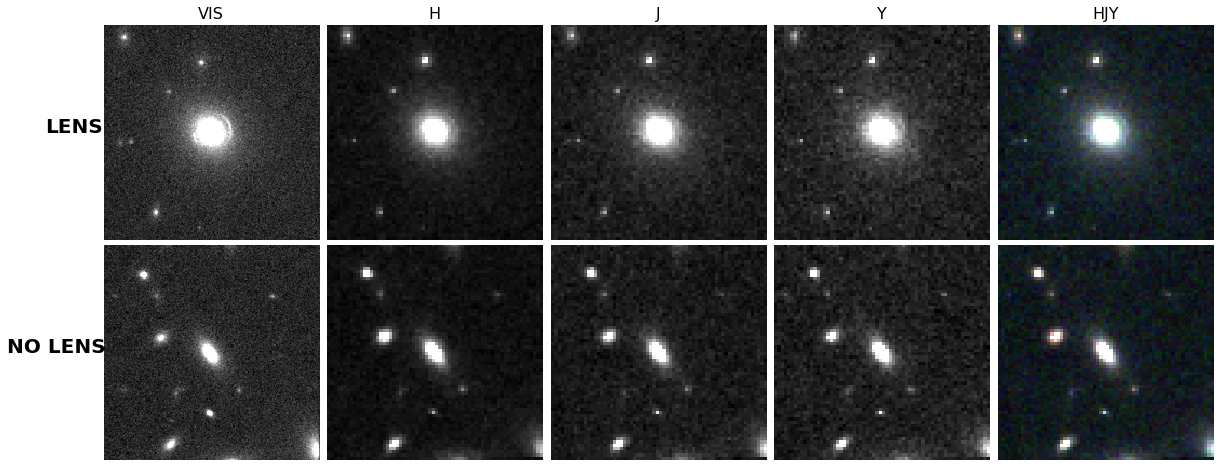

In [ ]:
lens = np.where(is_lens[:,1] == 1)[0]
nolens = np.where(is_lens[:,0] == 1)[0]
cut_lens = np.random.choice(lens)
cut_nolens = np.random.choice(nolens)
vis_lenses = images_vis0[cut_lens]
vis_nolens = images_vis0[cut_nolens]
hjy_lenses = images_hjy[cut_lens]
hjy_nolens = images_hjy[cut_nolens]

f, axs = plt.subplots(2, 5, figsize=[20,8], gridspec_kw={'hspace':0.02, 'wspace':0.01})

axs[0,0].imshow(vis_lenses, interpolation='nearest', cmap='gray')
axs[0,0].set_axis_off()
axs[0,0].annotate('LENS', (-20, 100), xytext=(-55,100),annotation_clip=False, fontsize=20, weight='bold')
axs[0,0].set_title('VIS', fontsize=16)
axs[0,1].imshow(hjy_lenses[:,:,:1], interpolation='nearest', cmap='gray')
axs[0,1].set_axis_off()
axs[0,1].set_title('H', fontsize=16)
axs[0,2].imshow(hjy_lenses[:,:,1:2], interpolation='nearest', cmap='gray')
axs[0,2].set_axis_off()
axs[0,2].set_title('J', fontsize=16)
axs[0,3].imshow(hjy_lenses[:,:,2:3], interpolation='nearest', cmap='gray')
axs[0,3].set_axis_off()
axs[0,3].set_title('Y', fontsize=16)
plot_hjy(hjy_lenses, ax=axs[0,4])
axs[0,4].set_axis_off()
axs[0,4].set_title('HJY', fontsize=16)

axs[1,0].imshow(vis_nolens, interpolation='nearest', cmap='gray')
axs[1,0].set_axis_off()
axs[1,0].annotate('NO LENS', (-20, 100), xytext=(-90,100),annotation_clip=False, fontsize=20, weight='bold')
axs[1,1].imshow(hjy_nolens[:,:,:1], interpolation='nearest', cmap='gray')
axs[1,1].set_axis_off()
axs[1,2].imshow(hjy_nolens[:,:,1:2], interpolation='nearest', cmap='gray')
axs[1,2].set_axis_off()
axs[1,3].imshow(hjy_nolens[:,:,2:3], interpolation='nearest', cmap='gray')
axs[1,3].set_axis_off()
plot_hjy(hjy_nolens, ax=axs[1,4])
axs[1,4].set_axis_off()

#plt.tight_layout()
plt.show()

Load the model weights

In [ ]:
model = keras.models.load_model(os.path.join(model_dir, 'efn2_hjy_vis_newpre_repeated_aug_new_fold5'))

Make the predictions

In [ ]:
preds = model.predict([images_vis, images_hjy])

Get metrics and plot them

In [ ]:
fpr, tpr, _ = sk_metrics.roc_curve(is_lens[:,1], preds[:,1])
auroc = sk_metrics.roc_auc_score(is_lens[:,1], preds[:,1])
precision, recall, _ = sk_metrics.precision_recall_curve(is_lens[:,1], preds[:,1])
prauc = sk_metrics.average_precision_score(is_lens[:,1], preds[:,1])

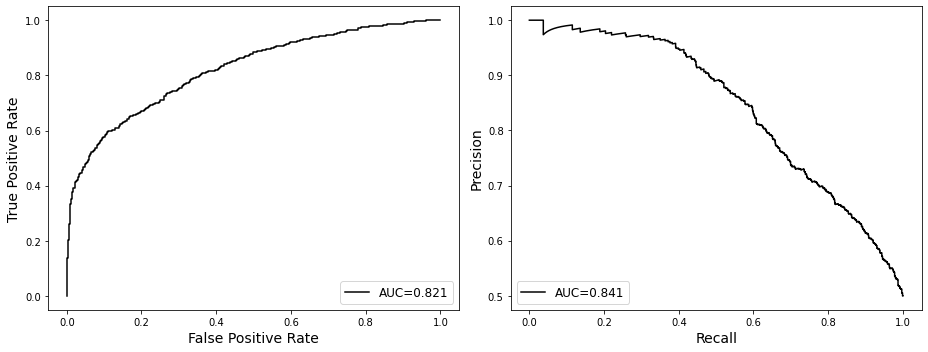

In [ ]:
f, ax = plt.subplots(1, 2, figsize=[13,5])
ax[0].plot(fpr, tpr, 'k-', label='AUC={:4.3f}'.format(auroc))
ax[0].set_xlabel('False Positive Rate', fontsize=14)
ax[0].set_ylabel('True Positive Rate', fontsize=14)
ax[0].legend(loc='lower right', fontsize=12)

ax[1].plot(recall, precision, 'k-', label='AUC={:4.3f}'.format(prauc))
ax[1].set_xlabel('Recall', fontsize=14)
ax[1].set_ylabel('Precision', fontsize=14)
ax[1].legend(loc='lower left', fontsize=12)

plt.tight_layout()
plt.show()